# Notebook Contents and Objective:
This notebook contains details experiment of Donut model Training, Evaluation and Inference. Also push model to Huggingface Hub

## S-0: Importing and Installing Dependencies

In [ ]:
!pip install -q transformers
!pip install -q datasets
!pip install transformers[sentencepiece]
!pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import json
from google.colab import data_table
import datasets
from datasets import Dataset, load_dataset, DatasetDict
import json
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
plt.style.use("dark_background")
import re
import random
from typing import Any, List, Tuple
from nltk import edit_distance
from PIL import Image

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity



import transformers
from transformers import DonutProcessor, VisionEncoderDecoderConfig, VisionEncoderDecoderModel, BartConfig
from transformers import get_scheduler


import torch
print("CUDA available:", torch.cuda.is_available())
# from donut import DonutModel
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from tqdm.auto import tqdm
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


# Progress bar
from tqdm.auto import tqdm

CUDA available: True


## S-1: Load Dataset from Huggingface
- 2000 `train`
- 400 `validation`

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' cr

In [ ]:
## Reload the train and valid dataset dict
processed_trn_vld_loaded = load_dataset("indra-inc/docvqa_en_train_valid_2400_gtparse")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
processed_trn_vld_loaded

DatasetDict({
    train: Dataset({
        features: ['question', 'docId', 'answers', 'data_split', 'bounding_boxes', 'word_list', 'image_raw', 'ground_truth'],
        num_rows: 2000
    })
    valid: Dataset({
        features: ['question', 'docId', 'answers', 'data_split', 'bounding_boxes', 'word_list', 'image_raw', 'ground_truth'],
        num_rows: 400
    })
})

In [ ]:
hf_train = processed_trn_vld_loaded['train']
hf_train

Dataset({
    features: ['question', 'docId', 'answers', 'data_split', 'bounding_boxes', 'word_list', 'image_raw', 'ground_truth'],
    num_rows: 2000
})

In [ ]:
hf_valid = processed_trn_vld_loaded['valid']
hf_valid

Dataset({
    features: ['question', 'docId', 'answers', 'data_split', 'bounding_boxes', 'word_list', 'image_raw', 'ground_truth'],
    num_rows: 400
})

## S-2: Creating model checkpoint

In [ ]:
# model_checkpoint = "naver-clova-ix/donut-base"
model_checkpoint = "naver-clova-ix/donut-base-finetuned-docvqa"
max_length = 128
image_size = [1280, 960]


config = VisionEncoderDecoderConfig.from_pretrained(model_checkpoint)
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length

processor = DonutProcessor.from_pretrained(model_checkpoint)
model = VisionEncoderDecoderModel.from_pretrained(model_checkpoint, config=config)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


## S-3: Creating DonutDataset class

In [ ]:
from torch.utils.data import Dataset

In [ ]:
## Final Class by combining altogether

new_special_tokens_list = []
# list with the newly added tokens. The purpose of this list is to keep track of the tokens that were added to the tokenizer.

## DonutDataset class inherits from the torch.utils.data.Dataset class and overrides its methods

class DonutDataset(Dataset):
  """
  Args:
      dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
      max_length: the max number of tokens for the target sequences
      split: whether to load "train", "validation" or "test" split
      ignore_id: ignore_index for torch.nn.CrossEntropyLoss
      prompt_start_token: the special token at the start of the sequences
      prompt_end_token: the special token at the end of the sequences
      sort_json_key: whether or not to sort the JSON keys
  """

  def __init__(
    self,
    dataset_name_or_path: str,    # Name of the dataset or the path containing huggingface datset
    max_length: int,              # the maximum number of tokens for the target sequences/prompt
    split: str = None,
    ignore_id: int = -100,        # ignore_index for torch.nn.CrossEntropyLoss
    task_start_token: str = "<s>",
    prompt_start_token: str = None,   # The special token at the start of the propmpt sequences
    # prompt_end_token: str = None,   # The special token at the end of the prompt sequences
    sort_json_key: bool = True,       # Whether or not to sort the JSON keys
):
    super().__init__()

    ## Variable Declaration

    self.max_length = max_length
    self.split = split
    self.ignore_id = ignore_id
    self.task_start_token = task_start_token
    self.prompt_start_token = prompt_start_token if prompt_start_token else task_start_token
    # self.prompt_end_token = prompt_end_token
    self.sort_json_key = sort_json_key

    self.dataset = dataset_name_or_path
    self.dataset_length = len(self.dataset)   # The length of the dataset is stored

    self.gt_prompt_sequences = []    # operation for every single row  *** Note: same as hf_examples['gt_prompt'] which we did for single custom function case
    # list stores the ground truth (gt) token sequences, which are generated using the json2token() method for each sample in the dataset

    ## S-1: Iterate over all rows of the dataset and creating gt_prompt from gt_parses
    for sample in self.dataset:   # each sample is a dictionary

      # print(sample["ground_truth"], '|||||', type(sample["ground_truth"]))

      ground_truth_jsob_obj = json.loads(sample["ground_truth"])   # convert a string representation of ground_truth a JSON object
      if "gt_parses" in ground_truth_jsob_obj:  # when multiple ground truths are available, e.g., docvqa
        assert isinstance(ground_truth_jsob_obj["gt_parses"], list)
        gt_jsons_list = ground_truth_jsob_obj["gt_parses"]    ## Stores the list of gt_parses value as gt_parses is the only key
      else:
        assert "gt_parse" in ground_truth_jsob_obj and isinstance(ground_truth_jsob_obj["gt_parse"], dict)
        gt_jsons_list = [ground_truth_jsob_obj["gt_parse"]]


      ## Appending the prompt using list comprehension with adding cls_token before and eos_token at the end
      # For DOCVQA task
      self.gt_prompt_sequences.append(
            [
              # processor.tokenizer.cls_token +
              self.json2token(
                  # gt_jsons_list,
                  gt_json,
                  # update_special_tokens_for_json_key=self.split == "train",
                  sort_json_key=self.sort_json_key,
                )
              + processor.tokenizer.eos_token

              for gt_json in gt_jsons_list  # iterate over every dictionary json from the gt_jsons list
            ]
        )

    # self.added_tokens([self.prompt_start_token, self.prompt_end_token])
    self.added_tokens([self.task_start_token, self.prompt_start_token])
    self.prompt_start_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_start_token)
    # self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    # print(self.gt_prompt_sequences)

  ## S-2: Function converts an ordered JSON object into a token sequence
  def json2token(self, json_obj: Any,  sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(json_obj) == dict:
      if len(json_obj) == 1 and "text_sequence" in json_obj:
        return json_obj["text_sequence"]
      else:
        output = ""
        if sort_json_key:
          keys = sorted(json_obj.keys(), reverse=True)
        else:
          keys = json_obj.keys()

        for k in keys:
          # if update_special_tokens_for_json_key:
            # self.add_tokens([fr"", fr""])
          self.added_tokens([fr"<s_{k}>", fr"</s_{k}>"])
          output += (
              fr"<s_{k}>"
              + self.json2token(json_obj[k], sort_json_key)
              + fr"</s_{k}>"
          )
        return output

    elif type(json_obj) == list:
      return r"<sep/>".join([self.json2token(item, sort_json_key) for item in json_obj])

    else:
      json_obj = str(json_obj)
      if f"<{json_obj}/>" in new_special_tokens_list:
        json_obj = f"<{json_obj}/>"  # for categorical special tokens
      return json_obj

  ## S-3: Custom function to add new starting and ending prompt tokens and embed it
  def added_tokens(self, list_of_tokens: List[str]):
    """
    Add special tokens to tokenizer and resize the token embeddings of the decoder
    """
    newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
    if newly_added_num > 0:
      model.decoder.resize_token_embeddings(len(processor.tokenizer))
      new_special_tokens_list.extend(list_of_tokens)

  ## S-4: Aligns the dataset length with the valid indices
  def __len__(self) -> int:
    return self.dataset_length - 1

  ## S-5: special method that allows objects to support indexing and accessing their elements using square bracket notation ([]).
  # It is invoked when you use square brackets to access an element of an object, like obj[key]
  def __getitem__(self, indx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Load image from image_path of given dataset_path and convert into input pixel value tensor
    Convert ground truth data into input_ids (tokenized string) which is nothing but decoder input ids
    Create clone tensor of decoder input ids for masking and model understanding task
    Returns:
        input_tensor : preprocessed image
        input_ids : tokenized gt_data
        labels : masked labels (model doesn't need to predict prompt and pad token)
    """
    sample = self.dataset[indx]

    # S-5.1: create input_tensor from image i.e pixel values
    try:
      ## ** Note: This image path part will vary as per task
      # pixel_values = processor(Image.open(sample['full_path_image']).convert("RGB"), random_padding=self.split == "train", return_tensors="pt").pixel_values
      pixel_values = processor(sample['image_raw'].convert("RGB"), random_padding = self.split =="train",
                               return_tensors="pt").pixel_values
      # torch.Size([1, 3, 2560, 1920]) shape before squeeze
      input_tensor_pixel = pixel_values.squeeze()

    except Exception as e:
      print(sample)
      print(f"Error: {e}")
      return {}

    # S-5.2: tokenize document and creating decoder input ids

    # processed_gt_prompt = self.gt_prompt_sequences[indx]  # can be more than one, e.g., DocVQA Task 1
    # random.choice() is in scenarios where you need to select a random element from a collection of items.
    processed_gt_prompt = random.choice(self.gt_prompt_sequences[indx])  # can be more than one, e.g., DocVQA Task 1
    decoder_input_ids = processor.tokenizer(
        processed_gt_prompt,
        add_special_tokens=False,
        max_length=self.max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)   #torch.Size([1, 128]) before squeeze

    # S-5.3: Create labels which is clone tensor for extracted values from decoder input ids tensors

    if self.split == "train":

      labels = decoder_input_ids.clone()    ## clone tensor of decoder input ids

      prompt_start_token_id_index = (labels == self.prompt_start_token_id).nonzero
      # prompt_end_token_id_index = (labels == self.prompt_end_token_id).nonzero

      labels[
          labels == processor.tokenizer.pad_token_id
      ] = self.ignore_id

      labels[
          : prompt_start_token_id_index().squeeze() + 1
      ] = self.ignore_id

      return input_tensor_pixel, decoder_input_ids, labels

    else:

      prompt_start_index = ((decoder_input_ids == self.prompt_start_token_id).nonzero)().squeeze()  # return prompt end index instead of target output labels

      return input_tensor_pixel, decoder_input_ids, prompt_start_index, processed_gt_prompt




In [ ]:
processor.image_processor.size = image_size[::-1] # should be (width, height)
processor.image_processor.do_align_long_axis = False

In [ ]:
train_dataset_sub = DonutDataset(hf_train, max_length=max_length, split="train",
                            task_start_token="<s_docvqa>", prompt_start_token="<s_answer>",
                            # prompt_end_token="</s_answer>",
                            sort_json_key=False,
                             )

valid_dataset_sub = DonutDataset(hf_valid, max_length=max_length,split="valid",
                            task_start_token="<s_docvqa>", prompt_start_token="<s_answer>",
                            # prompt_end_token="</s_answer>",
                            sort_json_key=False,
                             )

In [ ]:
train_dataset_sub, len(train_dataset_sub)

(<__main__.DonutDataset at 0x7dca4c0ef0a0>, 1999)

In [ ]:
valid_dataset_sub, len(valid_dataset_sub)

(<__main__.DonutDataset at 0x7dca4c0ef340>, 399)

In [ ]:
train_dataset_sub[0]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 tensor([57529, 27973, 52743, 48941, 44960, 40053, 35647, 25515, 54964, 36322,
   

In [ ]:
## Sample check of row 0 of train dataset
pixel_values_0, decoder_input_ids_0, labels_0  = train_dataset_sub[0]
for decoder_input_id, label in zip(decoder_input_ids_0.tolist()[:-1][:30], labels_0.tolist()[1:][:30]):
  if label != -100:
    print(processor.decode([decoder_input_id]), processor.decode([label]))
  else:
    print(processor.decode([decoder_input_id]), label)

<s_question> -100
what -100
is -100
the -100
date -100
mention -100
ed -100
in -100
this -100
letter -100
? -100
</s_question> -100
<s_answer> 1
1 /8
/8 /
/ 93
93 </s_answer>
</s_answer> </s>
</s> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100


In [ ]:
## Sample check of row 1 from training dataset
pixel_values_1, decoder_input_ids_1, labels_1  = train_dataset_sub[1]
for decoder_input_id, label in zip(decoder_input_ids_1.tolist()[:-1][:30], labels_1.tolist()[1:][:30]):
  if label != -100:
    print(processor.decode([decoder_input_id]), processor.decode([label]))
  else:
    print(processor.decode([decoder_input_id]), label)

<s_question> -100
what -100
is -100
the -100
contact -100
person -100
name -100
mention -100
ed -100
in -100
letter -100
? -100
</s_question> -100
<s_answer> P
P .
. Car
Car ter
ter </s_answer>
</s_answer> </s>
</s> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100


In [ ]:
valid_dataset_sub[0]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 tensor([57529, 42543, 52743, 48941, 22621, 26468, 39288, 33855, 37448,  4074,
   

In [ ]:
## Sample check of row 1 from valid dataset
pixel_values_1, decoder_input_ids_1, prompt_start_index_1, processed_gt_prompt_1  = valid_dataset_sub[1]
print(pixel_values_1)
print('******************************************')
print(processor.decode(decoder_input_ids_1))
print('******************************************')
print(prompt_start_index_1)
print('******************************************')
print(processed_gt_prompt_1)

tensor([[[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         ...,
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         ...,
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         ...,
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])
******************************************
<s_question> What is name of university?</s_question><s_answer>

## S-4: Creating PyTorch Dataloader

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# Empty cache
torch.cuda.empty_cache()

In [ ]:
train_dataloader_sub = DataLoader(train_dataset_sub, batch_size=2, shuffle = True, num_workers = 4)
valid_dataloader_sub = DataLoader(valid_dataset_sub, batch_size=2, shuffle = False, num_workers = 4)

In [ ]:
len(train_dataloader_sub), len(valid_dataloader_sub)

(1000, 200)

In [ ]:
batch = next(iter(train_dataloader_sub))
pixel_values, decoder_input_ids, labels = batch
print(pixel_values.shape)
print(decoder_input_ids.shape)
print(labels.shape)

torch.Size([2, 3, 1280, 960])
torch.Size([2, 128])
torch.Size([2, 128])


In [ ]:
pixel_values

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1.

In [ ]:
decoder_input_ids

tensor([[57529, 42543, 52743, 48941, 55435,  2334, 40053, 35647, 25515, 54964,
          7302, 36209, 57524, 57526, 50523, 57523,     2,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,  

In [ ]:
labels

tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100, 50523, 57523,     2,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  

In [ ]:
for decoder_input_id, label in zip(decoder_input_ids[0].tolist()[:-1][:30], labels[0].tolist()[1:][:30]):
  if label != -100:
    print(processor.decode([decoder_input_id]), processor.decode([label]))
  else:
    print(processor.decode([decoder_input_id]), label)

<s_question> -100
What -100
is -100
the -100
page -100
no -100
mention -100
ed -100
in -100
this -100
document -100
? -100
</s_question> -100
<s_answer> 24
24 </s_answer>
</s_answer> </s>
</s> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100


In [ ]:
len(processor.tokenizer)

57532

## S-5: Model Training and Evaluation using Raw PyTorch

In [ ]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(["<s_answer>"])[0]
## Note:
# Setting the decoder start token ID in the model's configuration to the ID of the <s_answer> token in the tokenizer.
# This token is used to indicate the start of the target sequence during decoding.

In [ ]:
config = {
    "verbose": True
}

In [ ]:
## Cosine Similarity Score of answer from whole string

def calculate_cosine_similarity(prediction, actual):
  start_token = "<s_answer>"
  # end_token = "</s_answer>"

  # Extract the <s_answer> and </s_answer> substrings
  prediction_answer = prediction[prediction.index(start_token) + len(start_token):]
  actual_answer = actual[actual.index(start_token) + len(start_token):]

  # Vectorize the extracted answers
  vectorizer = TfidfVectorizer()
  tfidf_matrix = vectorizer.fit_transform([prediction_answer, actual_answer])

  # Calculate cosine similarity
  similarity_score = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]
  return similarity_score



In [ ]:
## Finding Training Accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Set the optimizer
optimizer = Adam(model.parameters(), lr=3e-5)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
lambda1 = lambda epoch : epoch/10  #For each epoch, multiply epoch/10 * initial_lr
scheduler = lr_scheduler.LambdaLR(optimizer,lr_lambda=lambda1)

# Set the number of training epochs
num_epochs = 15

## Set up empty list to keep track of model progress
epoch_count = []
train_losses = []
accs = []
val_mean_accuracy = []

for epoch in range(num_epochs):

  # Training loop
  model.train()

  print(f"Epoch {epoch + 1}/{num_epochs}")

  total_loss = 0.0    # Total loss across all batches in an epoch
  total_correct = 0   # Total correct across all batches in an epoch
  total_samples = 0   # Effective when batch_size is more than 1
  total_samples_mask_level = 0 # Total number of non-padding and ignored tokens

  # Iterate over the training dataset
  for pixel_values, decoder_input_ids, labels in tqdm(train_dataloader_sub):

    pixel_values = pixel_values.to(device)
    decoder_input_ids = decoder_input_ids.to(device)
    labels = labels.to(device)

    ## Finding outputs prediction
    outputs = model(pixel_values=pixel_values, decoder_input_ids=decoder_input_ids[:, :-1], labels=labels[:, 1:])
    # print(outputs['loss'].shape, outputs['logits'].shape, outputs['encoder_last_hidden_state'].shape)

    ## Compute  the Loss
    loss = outputs.loss
    total_loss += loss.item()

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Compute the Accuracy (3-Ways)
    ## Pro-2
    total_samples += labels.size(0)   # # labels.size(0) = 1

    ## Pro-3 Mask level
    # Create a mask to exclude padding tokens & ignored tokens from accuracy calculation
    mask = (labels != -100)
    # Update the total number of non-padding tokens
    total_samples_mask_level += mask.sum().item()

    # Finding logits value
    logits = outputs.logits
    predictions = logits.argmax(dim=-1) # index value of maximum score for each token
    correct = (predictions == labels[:, 1:]).sum().item()    ## Number of correct in each row
    total_correct += correct    # Cumulative correct then lastly total correct prediction from each epoch

  scheduler.step()

  ## Average Loss Calculation
  avg_epoch_loss_batch_level = total_loss / len(train_dataloader_sub)   # average loss per batch i.e. normalize the loss value

  # Append the training losses and epoch count for plotting
  train_losses.append(avg_epoch_loss_batch_level)
  epoch_count.append(epoch)

  ## Average Accuracy Calculation
  avg_epoch_accuracy_batch_level = total_correct / len(train_dataloader_sub) # average per epoch accuracy at batch level (meaningful when batch size > 1)

  avg_epoch_accuracy_sample_level = total_correct / total_samples # average per epoch accuracy at based total number of data point

  avg_epoch_accuracy_mask_level = (total_correct / total_samples_mask_level) * 100 # average per epoch accuracy at based on mask or non padding tokens

  # If batch_size = 1 , so we can use anything len(train_dataloader_sub) or  len(train_dataset)

  print(f"Training Loss Batch Level: {avg_epoch_loss_batch_level:.4f} :::: Training Accuracy Batch Level: {avg_epoch_accuracy_batch_level:.3f}%")
  print(f"Training Accuracy Entire Sample Level: {avg_epoch_accuracy_sample_level:.3f}% :::: Training Accuracy Mask Level: {avg_epoch_accuracy_mask_level:.3f}%")
  print('*****************************************************************************************************************************')


  ## Validation section using Cosine Similarity
  model.eval()
  with torch.no_grad():
    for pixel_values, decoder_input_ids, prompt_start_indx, gt_prompt in tqdm(valid_dataloader_sub):
      # print(batch) ## printing all the details of four values in each row i.e pixel value, decoder_input_ids, prompt start token index and gt_prompt
      # print('*************************************************')

      pixel_values = pixel_values.to(device)
      decoder_input_ids = decoder_input_ids.to(device)
      prompt_start_indx = prompt_start_indx.to(device)
      gt_prompt = gt_prompt

      # print(pixel_values.shape, decoder_input_ids.shape, prompt_start_indx.shape)

      # # for decoder_input_id, ans_start_indx in zip(decoder_input_ids, prompt_start_indx):
      # #   print(decoder_input_id, ans_start_indx)

      decoder_input_question_ids = pad_sequence(
              [decoder_input_id[ : ans_start_indx + 1] for decoder_input_id, ans_start_indx in zip(decoder_input_ids, prompt_start_indx)],
              batch_first=True,
          )


      # print(decoder_gt_question_prompt, decoder_gt_question_prompt.shape)
      # e.g tensor([[    0, 57525, 42543, .... 36209, 57526, 57527]]) , torch.Size([1, 20])
      # print('*************************************************')

      outputs_gen = model.generate(pixel_values,
                                  decoder_input_ids = decoder_input_question_ids,
                                  max_length=max_length,
                                  early_stopping=True,
                                  pad_token_id=processor.tokenizer.pad_token_id,
                                  eos_token_id=processor.tokenizer.eos_token_id,
                                  use_cache=True,
                                  num_beams=1,
                                  bad_words_ids=[[processor.tokenizer.unk_token_id]],
                                  return_dict_in_generate=True,
                                  )

      # print(outputs_gen)
      # print(outputs_gen.sequences)
      # generated_sequences = outputs_gen.sequences
      # for sequence in generated_sequences:
      #   generated_text = processor.tokenizer.decode(sequence, skip_special_tokens=True)
      #   print(generated_text)

      # Process and evaluate the predictions and answers
      predictions = []
      for seq in processor.tokenizer.batch_decode(outputs_gen.sequences):
        # print(seq)
        seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
        seq = re.sub(r"<.*?>", "", seq, count=1).strip()
        # print(seq)
        predictions.append(seq)
      # print(predictions)

      scores = []
      for pred_prompt, actual_prompt in zip(predictions, gt_prompt):
        # print(pred_prompt)
        # print(actual_prompt)
        pred_prompt = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred_prompt)
        # print(pred_prompt)
        actual_prompt = re.sub(r"<.*?>", "", actual_prompt, count=1)
        actual_prompt = actual_prompt.replace(processor.tokenizer.eos_token, "")
        # print(actual_prompt)

        # model.get_encoder
        # # Calculate cosine similarity between pred_prompt and actual_prompt
        # pred_vector = model.get_encoder(pred_prompt)  # Replace 'model.encode' with the actual encoding function of your model
        # actual_vector = model.get_encoder(actual_prompt)  # Replace 'model.encode' with the actual encoding function of your model
        similarity_score = calculate_cosine_similarity(pred_prompt, actual_prompt)
        scores.append(similarity_score)
        accs.append(scores[0])


        # print(scores)

        if config.get("verbose", False) and len(scores) == 1:
          print(f"Predicted Answer: {pred_prompt}")
          print(f"Actual Answer: {actual_prompt}")
          print(f"Similarity Score: {scores[0]}")

      print('++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++')

  mean_acc = np.mean(accs)  # Calculate the mean accuracy score
  val_mean_accuracy.append(mean_acc)
  accuracy_percentage = mean_acc * 100  # Calculate the accuracy percentage

  print(f"Mean Validation Accuracy Score after Epoch {epoch + 1} is: {accuracy_percentage:.4f}")

  print(f"------------------------------------------>>> End of {epoch + 1} <<<-------------------------------------------------------")



Epoch 1/15


  0%|          | 0/1000 [00:00<?, ?it/s]

Training Loss Batch Level: 4.9593 :::: Training Accuracy Batch Level: 10.490%
Training Accuracy Entire Sample Level: 5.248% :::: Training Accuracy Mask Level: 67.239%
*****************************************************************************************************************************


  0%|          | 0/200 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>1980</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>itc limited report and accounts 2013</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>ITC Limited</s_answer>
Similarity Score: 0.5245910904457137
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: To whom is the document sent?</s_question><s_answer>jail</s_answer>
Actual Answer: To whom is the document sent?</s_question><s_answer>Paul</s_answer>
Similarity Score: 0.336

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Loss Batch Level: 2.1851 :::: Training Accuracy Batch Level: 10.817%
Training Accuracy Entire Sample Level: 5.411% :::: Training Accuracy Mask Level: 68.960%
*****************************************************************************************************************************


  0%|          | 0/200 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>1980</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>bnco</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>ITC Limited</s_answer>
Similarity Score: 0.26055567105626243
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: To whom is the document sent?</s_question><s_answer>paul</s_answer>
Actual Answer: To whom is the document sent?</s_question><s_answer>Paul</s_answer>
Similarity Score: 1.0000000000000002
+++++++++++++++++

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Loss Batch Level: 0.9268 :::: Training Accuracy Batch Level: 12.199%
Training Accuracy Entire Sample Level: 6.103% :::: Training Accuracy Mask Level: 78.491%
*****************************************************************************************************************************


  0%|          | 0/200 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>1980</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>Bnco</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>ITC Limited</s_answer>
Similarity Score: 0.26055567105626243
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: To whom is the document sent?</s_question><s_answer>taul</s_answer>
Actual Answer: To whom is the document sent?</s_question><s_answer>Paul</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Loss Batch Level: 0.6560 :::: Training Accuracy Batch Level: 13.108%
Training Accuracy Entire Sample Level: 6.557% :::: Training Accuracy Mask Level: 83.538%
*****************************************************************************************************************************


  0%|          | 0/200 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>1980</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>Bnco</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>itc limited</s_answer>
Similarity Score: 0.26055567105626243
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: To whom is the document sent?</s_question><s_answer>paul</s_answer>
Actual Answer: To whom is the document sent?</s_question><s_answer>Paul</s_answer>
Similarity Score: 1.0000000000000002
+++++++++++++++++

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Loss Batch Level: 0.5459 :::: Training Accuracy Batch Level: 13.407%
Training Accuracy Entire Sample Level: 6.707% :::: Training Accuracy Mask Level: 86.235%
*****************************************************************************************************************************


  0%|          | 0/200 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>1978</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>TTC limited report and accounts 2013</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>itc limited</s_answer>
Similarity Score: 0.2910691023819054
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: To whom is the document sent?</s_question><s_answer>paul</s_answer>
Actual Answer: To whom is the document sent?</s_question><s_answer>Paul</s_answer>
Similarity Score: 1.000

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Loss Batch Level: 0.4378 :::: Training Accuracy Batch Level: 13.803%
Training Accuracy Entire Sample Level: 6.905% :::: Training Accuracy Mask Level: 88.424%
*****************************************************************************************************************************


  0%|          | 0/200 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>1978</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>BINCO/TRUNK</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>itc limited</s_answer>
Similarity Score: 0.20199309249791833
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: To whom is the document sent?</s_question><s_answer>paul</s_answer>
Actual Answer: To whom is the document sent?</s_question><s_answer>Paul</s_answer>
Similarity Score: 1.0000000000000002
++++++++++

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Loss Batch Level: 0.4042 :::: Training Accuracy Batch Level: 13.926%
Training Accuracy Entire Sample Level: 6.966% :::: Training Accuracy Mask Level: 89.660%
*****************************************************************************************************************************


  0%|          | 0/200 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.24</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>TTC LIMITED REPORTAND ACCOUNTS 2017</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>itc limited</s_answer>
Similarity Score: 0.3187840217537793
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: To whom is the document sent?</s_question><s_answer>Taul</s_answer>
Actual Answer: To whom is the document sent?</s_question><s_answer>Paul</s_answer>
Similarity Score: 0.3360

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Loss Batch Level: 0.3722 :::: Training Accuracy Batch Level: 13.982%
Training Accuracy Entire Sample Level: 6.994% :::: Training Accuracy Mask Level: 90.212%
*****************************************************************************************************************************


  0%|          | 0/200 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.24</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>TTC LIMITED REPORT AND ACCOUNTS, 2013</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>ITC Limited</s_answer>
Similarity Score: 0.2910691023819054
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: To whom is the document sent?</s_question><s_answer>Taul</s_answer>
Actual Answer: To whom is the document sent?</s_question><s_answer>Paul</s_answer>
Similarity Score: 0.33

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Loss Batch Level: 0.3713 :::: Training Accuracy Batch Level: 14.151%
Training Accuracy Entire Sample Level: 7.079% :::: Training Accuracy Mask Level: 90.422%
*****************************************************************************************************************************


  0%|          | 0/200 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.22</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>TIC LIMICSI REPORT AND ACCOUNTS 2017</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>itc limited</s_answer>
Similarity Score: 0.12536693798731732
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: To whom is the document sent?</s_question><s_answer>Mr. William 455-8056</s_answer>
Actual Answer: To whom is the document sent?</s_question><s_answer>Paul</s_answer>
Simila

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Loss Batch Level: 0.3596 :::: Training Accuracy Batch Level: 14.186%
Training Accuracy Entire Sample Level: 7.097% :::: Training Accuracy Mask Level: 90.767%
*****************************************************************************************************************************


  0%|          | 0/200 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>1980</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>TTC</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>ITC Limited</s_answer>
Similarity Score: 0.26055567105626243
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: To whom is the document sent?</s_question><s_answer>A.M.</s_answer>
Actual Answer: To whom is the document sent?</s_question><s_answer>Paul</s_answer>
Similarity Score: 0.5797386715376658
++++++++++++++++++

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Loss Batch Level: 0.3145 :::: Training Accuracy Batch Level: 14.243%
Training Accuracy Entire Sample Level: 7.125% :::: Training Accuracy Mask Level: 91.495%
*****************************************************************************************************************************


  0%|          | 0/200 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>1980</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>Inc. Linitical</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>ITC Limited</s_answer>
Similarity Score: 0.20199309249791833
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: To whom is the document sent?</s_question><s_answer>jace</s_answer>
Actual Answer: To whom is the document sent?</s_question><s_answer>Paul</s_answer>
Similarity Score: 0.33609692727625756
++++++

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Loss Batch Level: 0.3591 :::: Training Accuracy Batch Level: 14.088%
Training Accuracy Entire Sample Level: 7.048% :::: Training Accuracy Mask Level: 90.761%
*****************************************************************************************************************************


  0%|          | 0/200 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>1975</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>TIC LIMITED REPORT AND ACCOUNTS</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>ITC Limited</s_answer>
Similarity Score: 0.3187840217537793
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: To whom is the document sent?</s_question><s_answer>Janjape</s_answer>
Actual Answer: To whom is the document sent?</s_question><s_answer>Paul</s_answer>
Similarity Score: 0.33609

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Loss Batch Level: 0.3219 :::: Training Accuracy Batch Level: 14.253%
Training Accuracy Entire Sample Level: 7.130% :::: Training Accuracy Mask Level: 91.695%
*****************************************************************************************************************************


  0%|          | 0/200 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.22</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>TIC</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>ITC Limited</s_answer>
Similarity Score: 0.26055567105626243
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: To whom is the document sent?</s_question><s_answer>WHILE YOU WEEKE OUT</s_answer>
Actual Answer: To whom is the document sent?</s_question><s_answer>Paul</s_answer>
Similarity Score: 0.19431434016858148
++

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Loss Batch Level: 0.3663 :::: Training Accuracy Batch Level: 14.214%
Training Accuracy Entire Sample Level: 7.111% :::: Training Accuracy Mask Level: 90.911%
*****************************************************************************************************************************


  0%|          | 0/200 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.22</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>itc limited</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>itc limited</s_answer>
Similarity Score: 1.0000000000000002
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: To whom is the document sent?</s_question><s_answer>A.M.</s_answer>
Actual Answer: To whom is the document sent?</s_question><s_answer>Paul</s_answer>
Similarity Score: 0.5797386715376658
+++++++++++

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Loss Batch Level: 0.3492 :::: Training Accuracy Batch Level: 14.170%
Training Accuracy Entire Sample Level: 7.089% :::: Training Accuracy Mask Level: 90.956%
*****************************************************************************************************************************


  0%|          | 0/200 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.22</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>The United Re:000</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>ITC Limited</s_answer>
Similarity Score: 0.1506401849870651
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: To whom is the document sent?</s_question><s_answer>Mr. Ms.</s_answer>
Actual Answer: To whom is the document sent?</s_question><s_answer>Paul</s_answer>
Similarity Score: 0.2605556710562624
++

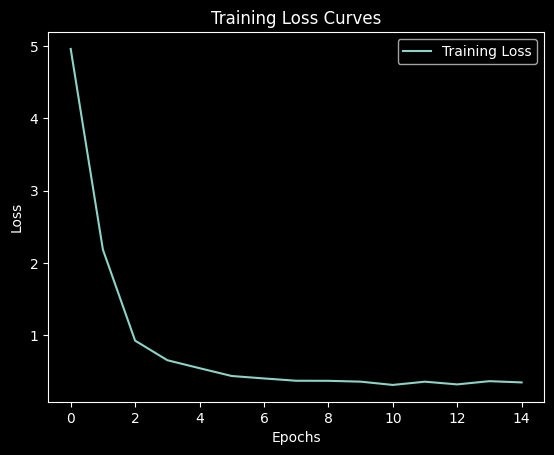

In [ ]:
plt.plot(epoch_count, train_losses, label='Training Loss')
plt.title("Training Loss Curves")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [ ]:
# plt.plot(epoch_count, val_mean_accuracy, label='Validation Accuracy')
# plt.title("Validation Cosine Score Accuracy Curves")
# plt.xlabel('Epochs')
# plt.ylabel('Mean Accuracy')
# plt.legend();

## S-6: Save the Processor and Push trained model to Hub

In [ ]:
processor.save_pretrained("/content/drive/MyDrive/Donut_Model_Processor/processor_2400")

In [ ]:
model.push_to_hub("indra-inc/donut_qa_model_docvqa_en_2400_finetuned")

pytorch_model.bin:   0%|          | 0.00/803M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/indra-inc/donut_qa_model_docvqa_en_2400_finetuned/commit/360f2fbf65278339bd5399202365059a1580e2cd', commit_message='Upload model', commit_description='', oid='360f2fbf65278339bd5399202365059a1580e2cd', pr_url=None, pr_revision=None, pr_num=None)

## S-7: Loading and Inference Check

In [ ]:
# new_model_checkpoint = "indra-inc/donut_qa_model_docvqa_en_2400_finetuned"
# loaded_processor = DonutProcessor.from_pretrained(new_model_checkpoint)
# loaded_model = VisionEncoderDecoderModel.from_pretrained(new_model_checkpoint)

In [ ]:
# def token2json(seq_string):
#   if "</s_answer>" in seq_string:
#       start_tag = "<s_answer>"
#       end_tag = "</s_answer>"
#   else:
#       seq_string = seq_string + "</s_answer>"
#       start_tag = "<s_answer>"
#       end_tag = "</s_answer>"

#   start_index = seq_string.find(start_tag)  ## <
#   end_index = seq_string.find(end_tag)      ## <

#   if start_index != -1 and end_index != -1 and start_index < end_index:
#     answer = seq_string[start_index + len(start_tag):end_index].strip()
#     if not answer:
#         answer = "No Answer Found"
#     seq_string = seq_string[:start_index + len(start_tag)] + answer + seq_string[end_index:]

#   result = loaded_processor.token2json(seq_string)
#   return result

In [ ]:
# ## 2. test prediction from any image along with any question asked by the user input

# ## Test Inference custom function for DOCVQA
# def run_prediction(user_test_sample, model=loaded_model, processor=loaded_processor):
#   device = "cuda" if torch.cuda.is_available() else "cpu"
#   model.to(device)

#   user_test_image = Image.open(user_test_sample).convert("RGB")
#   # display(user_test_image)

#   pixel_values = processor(user_test_image, return_tensors="pt").pixel_values
#   # print(pixel_values.shape)

#   user_task_prompt = "<s_doCvqa><s_question>{user_input}</s_question><s_answer>"
#   user_question =   str(input("Write your Question: "))                       ## "When is the coffee break?"
#   prompt = user_task_prompt.replace("{user_input}", user_question)
#   decoder_input_ids = processor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

#   test_outputs = model.generate(pixel_values.to(device),
#                                decoder_input_ids = decoder_input_ids.to(device),
#                                max_length = model.decoder.config.max_position_embeddings,
#                                early_stopping = True,
#                                pad_token_id = processor.tokenizer.pad_token_id,
#                                eos_token_id = processor.tokenizer.eos_token_id,
#                                use_cache = True,
#                                num_beams = 1,
#                                bad_words_ids = [[processor.tokenizer.unk_token_id]],
#                                return_dict_in_generate = True,
#                                output_scores = True)

#   test_seq_prediction = processor.batch_decode(test_outputs.sequences)[0]
#   test_seq_prediction = test_seq_prediction.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
#   test_seq_prediction = re.sub(r"<.*?>", "", test_seq_prediction, count=1).strip()  # remove first task start token
#   # print(test_seq_prediction)

#   test_seq_prediction_json = token2json(test_seq_prediction)
#   # test_seq_prediction_json = processor.token2json(test_seq_prediction)

#   return test_seq_prediction_json



In [ ]:
# ## User image path
# test_img_1 = '  '

# user_json_result = run_prediction(test_img_1)
# user_json_result